In [1]:
import sys
import os

# Add the pyquantifier directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from collections import Counter
import numpy as np
from scipy.stats import beta, uniform

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.data import Item, Dataset

# Purpose of this Notebook

Implementing some alternative calibration curve methods and using this notebook to test them out.

1. Generate a dataset with known class-conditional densities and known prevalence
2. Subsample to create a calibration sample
3. Fit a calibration curve to the calibration sample using different methods
- BinnedCalibrationCurve
- PiecewiseLinearCalibrationCurve
- WeightedPiecewiseLinearCalibrationCurve
- Platt scaling
- Isotonic regression
- Temperature scaling
4. Evaluate the calibration curves on the full base dataset: which come closest to recovering the correct prevalence estimate

## 1 Intrinsic data generator

### 1.1 Generate dataset

In [3]:
def generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    num_pos_item = int(p_pos * num_base_size)
    num_neg_item = num_base_size - num_pos_item

    scores_of_pos_items = pos_density_rv.generate_data(num_pos_item)
    scores_of_neg_items = neg_density_rv.generate_data(num_neg_item)

    items = []
    gt_label_dict = {}
    item_idx = 0

    for score in scores_of_pos_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'pos'
        item_idx += 1
    
    for score in scores_of_neg_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'neg'
        item_idx += 1

    dataset = Dataset(items=items)
    return dataset, gt_label_dict

In [4]:
pos_density_rv = MixtureCUD(components=[beta(10, 2), uniform(0, 1)], weights=[1, 0])
neg_density_rv = MixtureCUD(components=[beta(2, 5), uniform(0, 1)], weights=[1, 0])

p_pos = 0.2

num_base_size = 10000
num_bin = 10

In [5]:
intrinsic_base_dataset, intrinsic_gt_label_dict = generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size)

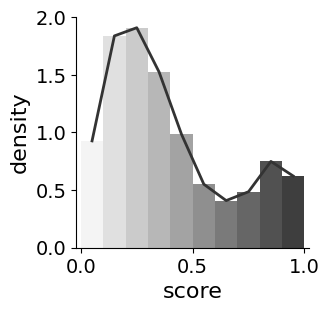

In [6]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=10)
intrinsic_base_dataset.classifier_score_distribution.plot()

In [7]:
# ground truth prevalence
Counter(intrinsic_gt_label_dict.values())["pos"] / num_base_size

0.2

### 1.2 Subsample calibration sample

In [8]:
num_sample = 1500

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='Predicted Probability', ylabel='Fraction of Positives'>],
      dtype=object)

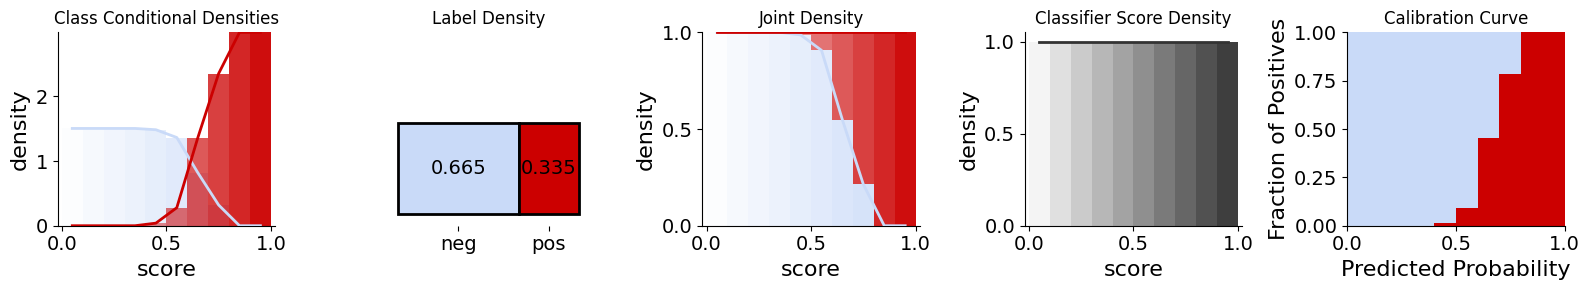

In [9]:
# 2. Select a subset of the dataset and annotate the labels
intrinsic_selected_dataset, intrinsic_selection_weights = (
    intrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample, strategy="uniform", bins=num_bin
    )
)
annotated_labels = [
    intrinsic_gt_label_dict[uid]
    for uid in intrinsic_selected_dataset.df["uid"].values.astype(int)
]
intrinsic_selected_dataset.annotate_sample(annotated_labels)

intrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [10]:
binning_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [12]:
intrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
ps_calibration_curve = intrinsic_selected_dataset.calibration_curve

# estimated_w, estimated_b = ps_calibration_curve.get_params()
# estimated_w = estimated_w.item()
# estimated_b = estimated_b.item()

# print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

In [13]:
intrinsic_selected_dataset.update_calibration_curve(method="piecewise linear")
piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [14]:
intrinsic_selected_dataset.update_calibration_curve(method="adjusted piecewise linear")
adjusted_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [15]:
intrinsic_selected_dataset.update_calibration_curve(method="isotonic regression")
isotonic_calibration_curve = intrinsic_selected_dataset.calibration_curve

AttributeError: 'IsotonicRegression' object has no attribute 'predict_proba'

### 1.4 Show plots, including Prevalence estimation

In [16]:
labels = ['pos', 'neg']

In [18]:
for cc in [
    binning_calibration_curve,
    piecewise_linear_calibration_curve,
    adjusted_piecewise_linear_calibration_curve,
    ps_calibration_curve,
    isotonic_calibration_curve,
]:
    jd = ExtrinsicJointDistribution(labels, intrinsic_base_dataset.classifier_score_distribution, cc)
    print(intrinsic_base_dataset.extrinsic_estimate(calibration_curve=cc))
    print(cc.get_calibrated_prob(np.linspace(0, 1, 11)))
    jd.plot_five_distributions()

NameError: name 'isotonic_calibration_curve' is not defined